# Создание фичей

## Импорт библиотек

In [67]:
from binance.client import Client
from binance.um_futures import UMFutures
from binance.websocket.um_futures.websocket_client import UMFuturesWebsocketClient
from binance.lib.utils import config_logging
import pandas as pd
import numpy as np
import talib
import keys
import time
from datetime import datetime
from pytz import timezone
import logging
import requests
import json
import re
import matplotlib.pyplot as plt
import seaborn as sbn
pd.options.mode.chained_assignment = None # отключение предупреждения
pd.set_option('display.max_columns', None) # показывать максимальное количесвто столбцов

https://github.com/binance/binance-futures-connector-python

## Загрузка локальных данных

In [36]:
df_1 = pd.read_csv('ds_moodeng_10_06.csv')

In [37]:
df_2 = pd.read_csv('ds_moodeng_12_06.csv')

In [38]:
df_3 = pd.read_csv('ds_moodeng_13_06.csv')

In [39]:
display(df_1.head(2))
display(df_2.head(2))
display(df_3.head(2))
print(df_1.shape)
print(df_2.shape)
print(df_3.shape)

,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10
0,0.21362,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,3061.0,24.0,0.0,5518.0,2082.0,19713.0,5623.0,8195.0,11100.0,13169.0,12274.0,18951.0
1,0.21436,4743.0,0.0,111.0,2383.0,8931.0,11723.0,27194.0,11688.0,5483.0,6326.0,3338.0,2090.0,5013.0,3457.0,3701.0,11101.0,11165.0,8857.0,7052.0,1982.0


,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10
0,0.252345,3703.0,6265.0,11454.0,14442.0,10746.0,36659.0,14244.0,13852.0,12172.0,25165.0,0.0,0.0,0.0,0.0,1448.0,0.0,27.0,329.0,1027.0,7125.0
1,0.252185,6745.0,14719.0,17147.0,18057.0,34893.0,16428.0,14392.0,9029.0,21637.0,9566.0,27.0,2160.0,809.0,4309.0,8453.0,9843.0,3184.0,5735.0,4928.0,7680.0


,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10
0,0.181320,0.0,0.0,682.0,1181.0,92.0,2260.0,3608.0,12037.0,11999.0,10682.0,19907.0,10880.0,13755.0,11149.0,17445.0,10746.0,10512.0,8913.0,30174.0,18602.0
1,0.183575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,10164.0,8380.0,9340.0,10859.0,11561.0,19656.0,16396.0,39309.0,15262.0,18617.0


(19809, 21)
(5384, 21)
(63221, 21)


### Объединение датафреймов

In [40]:
df = pd.concat([df_1, df_2, df_3]).reset_index(drop=True)

In [41]:
df.shape

(88414, 21)

## Создание новых признаков

In [42]:
df.columns

Index(['mid_price', 'ask_1', 'ask_2', 'ask_3', 'ask_4', 'ask_5', 'ask_6',
       'ask_7', 'ask_8', 'ask_9', 'ask_10', 'bid_1', 'bid_2', 'bid_3', 'bid_4',
       'bid_5', 'bid_6', 'bid_7', 'bid_8', 'bid_9', 'bid_10'],
      dtype='object')

In [43]:
bids = ['bid_1', 'bid_2', 'bid_3', 'bid_4',
       'bid_5', 'bid_6', 'bid_7', 'bid_8', 'bid_9', 'bid_10']

In [44]:
asks = ['ask_1', 'ask_2', 'ask_3', 'ask_4', 'ask_5', 'ask_6',
       'ask_7', 'ask_8', 'ask_9', 'ask_10']

### Имбаланс объемов

Volume Imbalance = (∑ Bid Size − ∑ Ask Size) / (∑ Bid Size + ∑ Ask Size)

In [45]:
df.head(2)

,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10
0,0.21362,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,3061.0,24.0,0.0,5518.0,2082.0,19713.0,5623.0,8195.0,11100.0,13169.0,12274.0,18951.0
1,0.21436,4743.0,0.0,111.0,2383.0,8931.0,11723.0,27194.0,11688.0,5483.0,6326.0,3338.0,2090.0,5013.0,3457.0,3701.0,11101.0,11165.0,8857.0,7052.0,1982.0


In [46]:
df['imbalance_vol'] = (df[bids].sum(axis=1) - df[asks].sum(axis=1)) / (df[bids].sum(axis=1) + df[asks].sum(axis=1))

Рассчитанный признак должен быть в диапазоне [-1, 1], проверим:

In [47]:
df['imbalance_vol'].describe()

count    88323.000000
mean        -0.014611
std          0.533876
min         -1.000000
25%         -0.403116
50%         -0.022153
75%          0.365023
max          1.000000
Name: imbalance_vol, dtype: float64

### Уровень цены максимального аска/бида

In [48]:
df['max_ask_level'] = df.iloc[:, 1:11].apply(lambda x: df.columns[1:11][x.argmax()], axis = 1).astype(
    str).str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

In [49]:
df['max_bid_level'] = df.iloc[:, 11:21].apply(lambda x: df.columns[11:21][x.argmax()], axis = 1).astype(
    str).str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

In [50]:
df.columns[11:21]

Index(['bid_1', 'bid_2', 'bid_3', 'bid_4', 'bid_5', 'bid_6', 'bid_7', 'bid_8',
       'bid_9', 'bid_10'],
      dtype='object')

In [51]:
df.head(2)

,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,max_ask_level,max_bid_level
0,0.21362,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,3061.0,24.0,0.0,5518.0,2082.0,19713.0,5623.0,8195.0,11100.0,13169.0,12274.0,18951.0,0.937615,9,4
1,0.21436,4743.0,0.0,111.0,2383.0,8931.0,11723.0,27194.0,11688.0,5483.0,6326.0,3338.0,2090.0,5013.0,3457.0,3701.0,11101.0,11165.0,8857.0,7052.0,1982.0,-0.152753,7,7


### Среднее значение объемов

In [52]:
df['asks_mean'] = df[asks].mean(axis=1)

In [53]:
df['bids_mean'] = df[bids].mean(axis=1)

### Медианное значение объемов

In [54]:
df['asks_median'] = df[asks].median(axis=1)

In [55]:
df['bids_median'] = df[bids].median(axis=1)

### Стандартное отклонение

In [56]:
df['asks_std'] = df[asks].std(axis=1).round(1)

In [57]:
df['bids_std'] = df[bids].std(axis=1).round(1)

In [58]:
df.head(2)

,mid_price,ask_1,ask_2,ask_3,ask_4,ask_5,ask_6,ask_7,ask_8,ask_9,ask_10,bid_1,bid_2,bid_3,bid_4,bid_5,bid_6,bid_7,bid_8,bid_9,bid_10,imbalance_vol,max_ask_level,max_bid_level,asks_mean,bids_mean,asks_median,bids_median,asks_std,bids_std
0,0.21362,0.0,0.0,0.0,0.0,0.0,0.0,26.0,0.0,3061.0,24.0,0.0,5518.0,2082.0,19713.0,5623.0,8195.0,11100.0,13169.0,12274.0,18951.0,0.937615,9,4,311.1,9662.5,0.0,9647.5,966.3,6624.4
1,0.21436,4743.0,0.0,111.0,2383.0,8931.0,11723.0,27194.0,11688.0,5483.0,6326.0,3338.0,2090.0,5013.0,3457.0,3701.0,11101.0,11165.0,8857.0,7052.0,1982.0,-0.152753,7,7,7858.2,5775.6,5904.5,4357.0,7986.6,3538.8


### Целевой признак

target создаем на основе признака mid_price, сдвигая его вверх на n кол-во шагов. Далее находим разницу между сдвинутым признаком и оригинальным.

In [59]:
df['target'] = df['mid_price'].shift(-5) - df['mid_price']

Ограничим датафрейм разумными пределами target

In [62]:
df = df.query('-0.01 < target < 0.01')

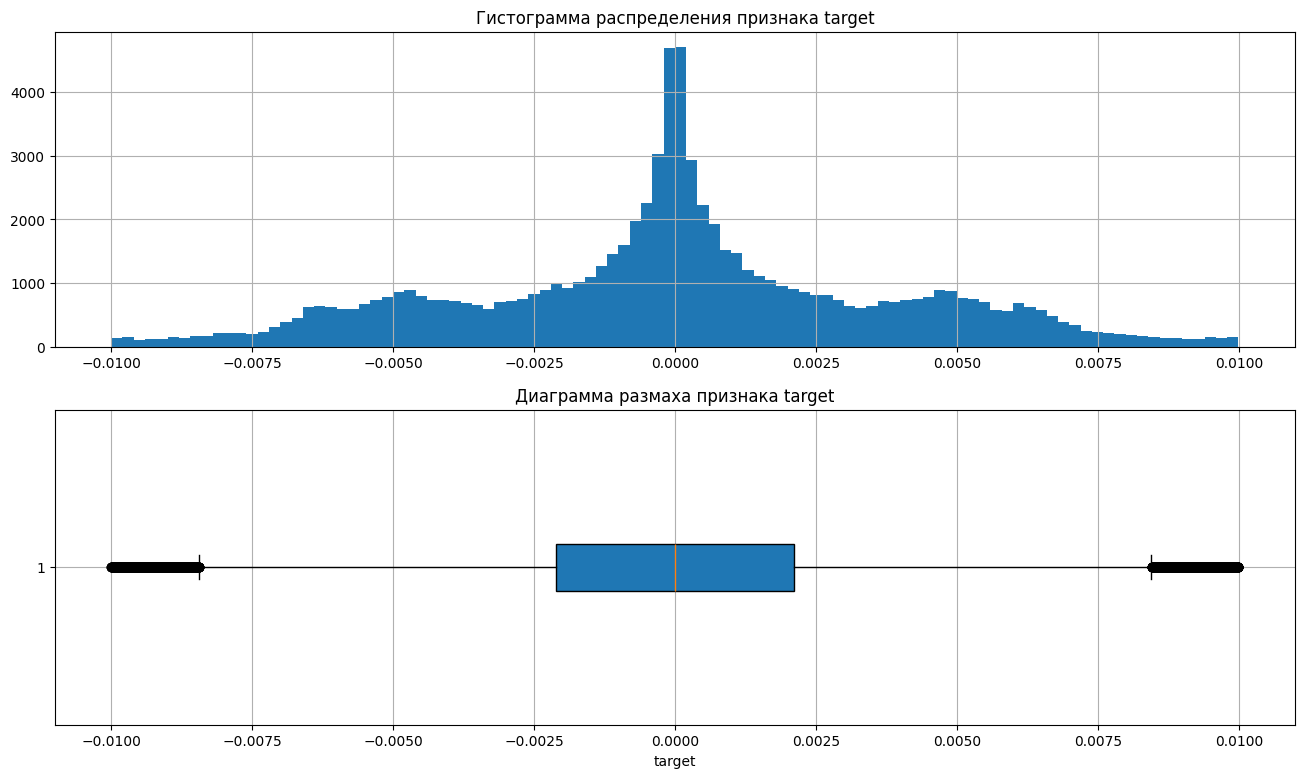

In [63]:
plt.figure(figsize = (16,9))
plt.subplot(2,1,1)
plt.hist(df['target'], bins = 100)
plt.title('Гистограмма распределения признака target')
plt.grid()
plt.subplot(2, 1, 2)
plt.boxplot(df['target'], vert=False, patch_artist=True)
plt.title('Диаграмма размаха признака target')
plt.xlabel('target')
plt.grid()
plt.show();

In [64]:
df.shape

(79012, 31)

Вывод: целевой признак имеет нормальное распределение. Оставим немного выбросов, как возможные аномальные значения. 

### Корреляция признаков

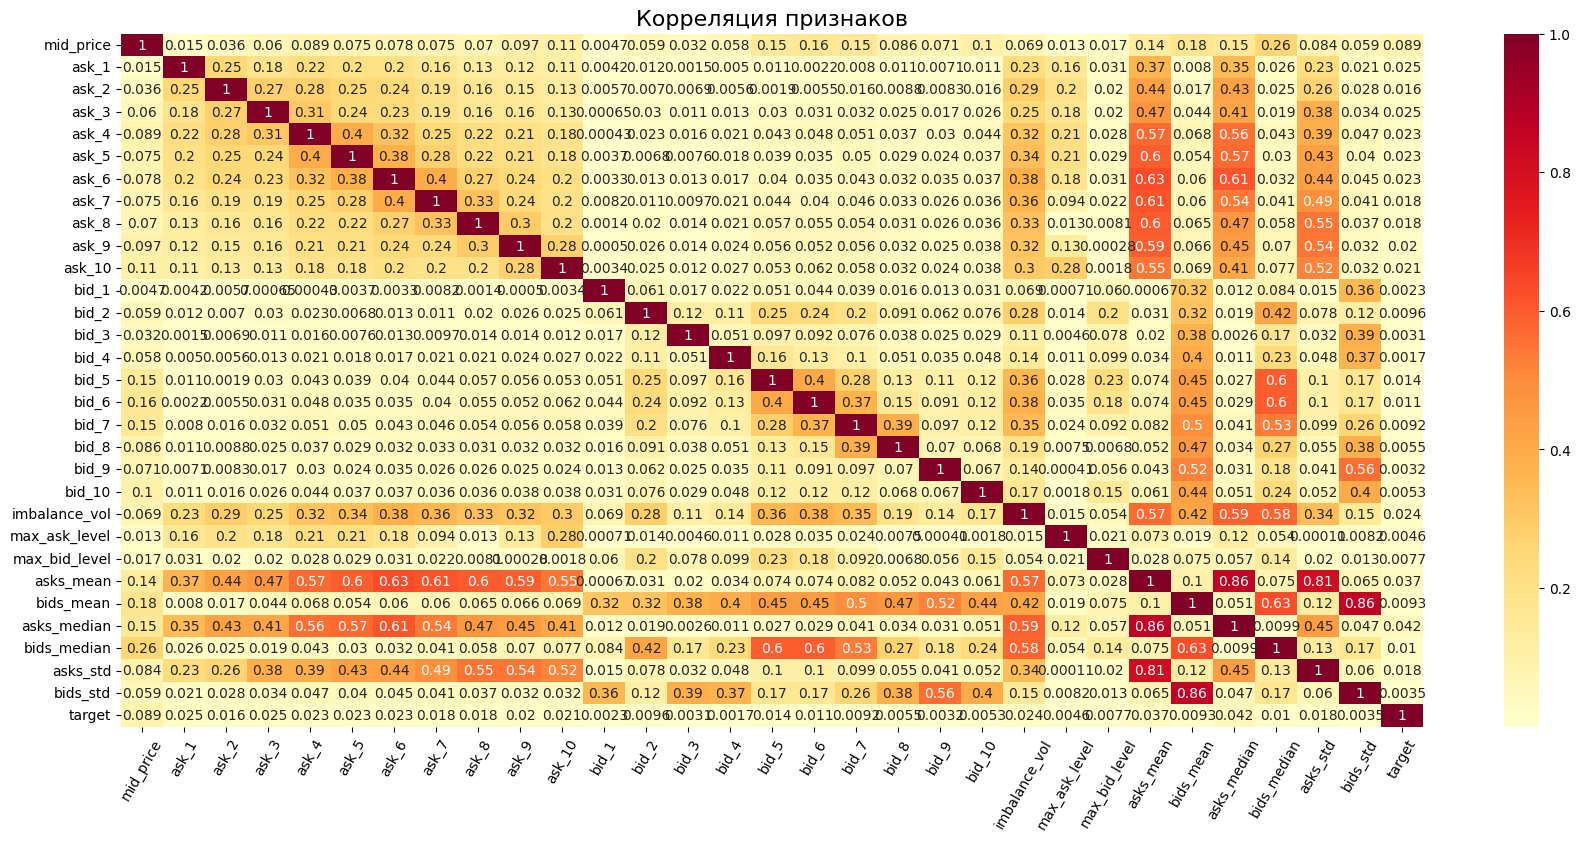

In [65]:
plt.figure(figsize=(21, 9))
fig = sbn.heatmap(df.corr().abs(), cmap='YlOrRd', annot=True)
plt.title('Корреляция признаков', fontsize=16)
plt.setp(fig.get_xticklabels(), rotation=60)
plt.show()

Вывод: высокая корреляция target с другими признаками отсутствует.

### Выгрузка датафрейма

In [ ]:
df.to_csv('ds_tot_5_step.csv', index = False)